# Population static time series released by World Food Programme (WFP)

In this notebook, we create *static time series* regarding the population for the administrative regions of each country.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
plt.style.use("default")

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from MapPlot.MapPlot import choropleth

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
path = "./WFP_data/"

dfs = []

all_files = glob.glob(path + "*.csv")
for filename in all_files:
    df = pd.read_csv(filename)
    dfs.append(df)

In [5]:
# Concatenate data.
df = pd.concat(dfs, axis = 0, ignore_index = True)
df.head()

,adm0_name,adm0_code,adm1_name,adm1_code,population
0,Burkina Faso,42,BOUCLE-DU-MOUHOUN,900712.0,1816310
1,Burkina Faso,42,CASCADES,900713.0,755896
2,Burkina Faso,42,CENTRE,900714.0,2623394
3,Burkina Faso,42,CENTRE-EST,900715.0,2623394
4,Burkina Faso,42,CENTRE-NORD,900716.0,1551284


In [6]:
# Change the name of adminstrata feature.
df.rename(columns = {"adm0_name": "Country", "adm1_name": "AdminStrata", "population": "Population"}, inplace = True)
# Delete geometry feature.
df.drop(columns = ["adm0_code", "adm1_code"], inplace = True)
# Delete duplicate rows if exist.
df = df.drop_duplicates()
df.head()

,Country,AdminStrata,Population
0,Burkina Faso,BOUCLE-DU-MOUHOUN,1816310
1,Burkina Faso,CASCADES,755896
2,Burkina Faso,CENTRE,2623394
3,Burkina Faso,CENTRE-EST,2623394
4,Burkina Faso,CENTRE-NORD,1551284


In [7]:
# The strings of the administrative regions of Burkina Faso, we change them to obtain lowercase with first capital letter.
def to_lower(country, admin):
    if country in ["Burkina Faso"]:
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

In [8]:
# Rename the name of some administrative regions of Cameroon.
df.loc[df.Country == "Cameroon", "AdminStrata"] = df.loc[df.Country == "Cameroon", "AdminStrata"].replace(["Extrême-Nord", "Nord", "Nord-Ouest", "Ouest", "Centre", "Est", "Adamaoua", "Sud-Ouest", "Sud"], 
                                                                                                          ["Far-North", "North", "North-West", "West", "Central", "East", "Adamawa", "South-West", "South"])

In [9]:
# Rename the name of some administrative regions of Mali.
df.loc[df.Country == "Mali", "AdminStrata"] = df.loc[df.Country == "Mali", "AdminStrata"].replace(["Tombouctou", "Gao"], 
                                                                                                  ["Tombouctou-Taoudeni", "Gao-Menaka"])

## Creation of the time series

In [10]:
# Create multi-index columns dataframe.
df = df.set_index(["Country", "AdminStrata"]).T.reset_index(drop = True)
df.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["Population"]), df.columns)), 
                                       names = ["Country", "AdminStrata", "Indicator"])
df

Country          Burkina Faso                                               \
AdminStrata Boucle-Du-Mouhoun   Cascades     Centre Centre-Est Centre-Nord   
Indicator          Population Population Population Population  Population   
0                     1816310     755896    2623394    2623394     1551284   

Country                                                                  ...  \
AdminStrata Centre-Ouest Centre-Sud        Est Hauts-Bassins       Nord  ...   
Indicator     Population Population Population    Population Population  ...   
0                1510412     801374    1633891       1983881    1500082  ...   

Country           Mali                 Niger                                   \
AdminStrata Gao-Menaka      Kayes     Zinder      Diffa     Niamey     Agadez   
Indicator   Population Population Population Population Population Population   
0               724465    2380144    4889058     765478     897588     510554   

Country                                                  
AdminStrata      Dosso     Maradi     Tahoua  Tillaberi  
Indicator   Population Population Population Population  
0              2446823    4373921    4634664    3924865  

[1 rows x 79 columns]

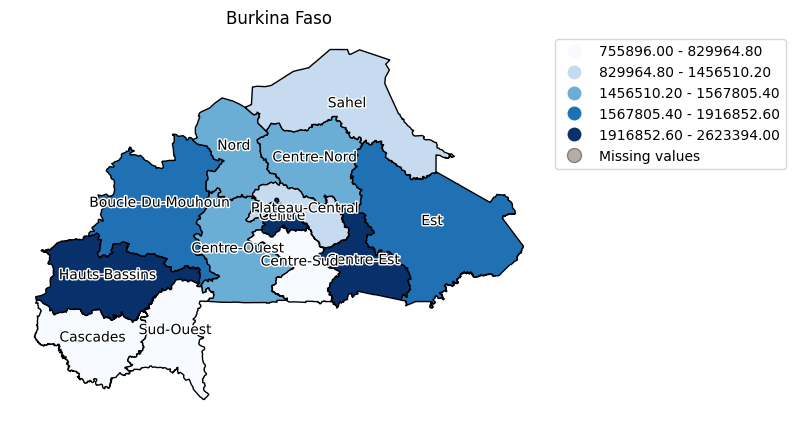

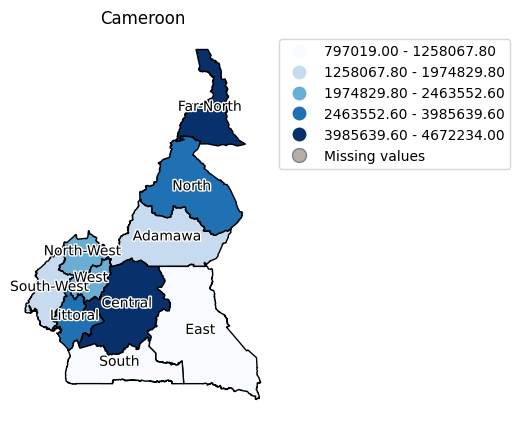

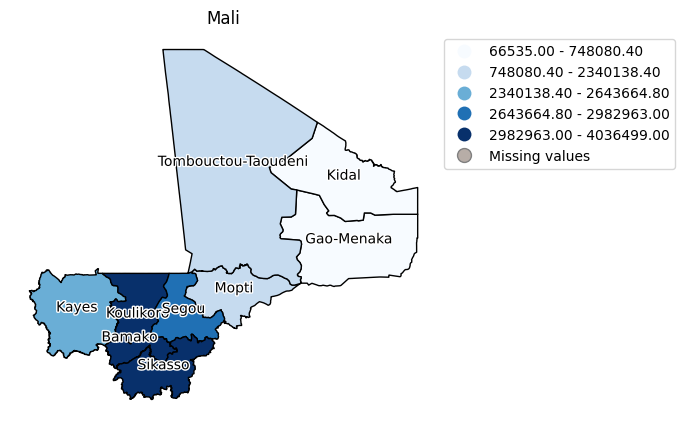

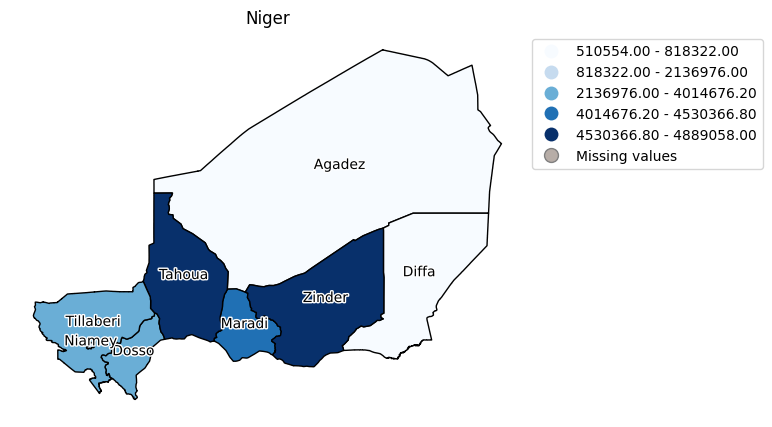

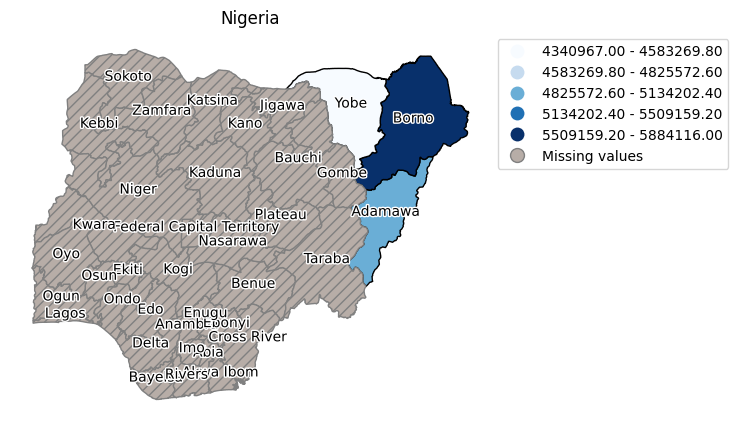

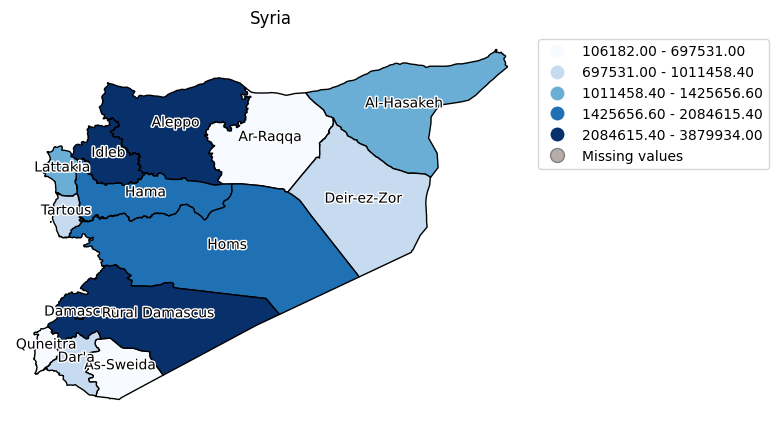

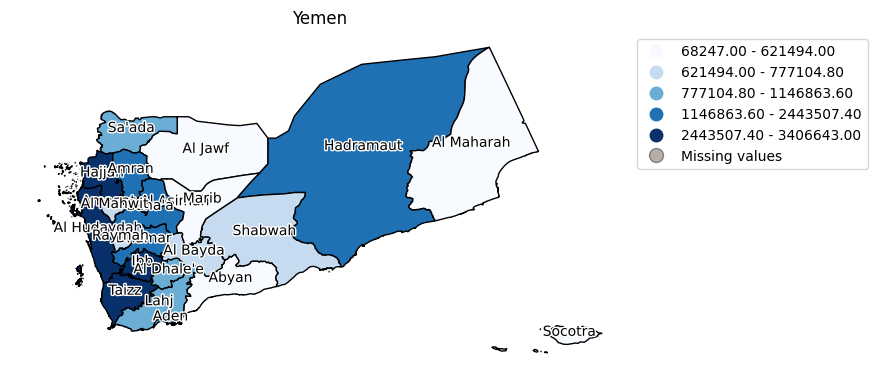

In [11]:
# Plot a choropleth map of the populations.
for country in df.columns.levels[0]:
    # Define pandas serie quantiles.
    quantiles = df[country].droplevel(level = 1, axis = 1).loc[0]
    # Plot map.
    choropleth(country, quantiles, figsize = (8, 5), cmap = "Blues", annotation = True)

In [12]:
# Define two years between which we decide to build the time series.
FIRST_YEAR = "2018"
LAST_YEAR = "2023"

new_index = pd.date_range(FIRST_YEAR, LAST_YEAR, freq = "D")

In [13]:
# Create static time series of the population.
df = df.loc[df.index.repeat(len(new_index))]
df.index = new_index
df.index.name = "Datetime"
df

Country          Burkina Faso                                               \
AdminStrata Boucle-Du-Mouhoun   Cascades     Centre Centre-Est Centre-Nord   
Indicator          Population Population Population Population  Population   
Datetime                                                                     
2018-01-01            1816310     755896    2623394    2623394     1551284   
2018-01-02            1816310     755896    2623394    2623394     1551284   
2018-01-03            1816310     755896    2623394    2623394     1551284   
2018-01-04            1816310     755896    2623394    2623394     1551284   
2018-01-05            1816310     755896    2623394    2623394     1551284   
...                       ...        ...        ...        ...         ...   
2022-12-28            1816310     755896    2623394    2623394     1551284   
2022-12-29            1816310     755896    2623394    2623394     1551284   
2022-12-30            1816310     755896    2623394    2623394     1551284   
2022-12-31            1816310     755896    2623394    2623394     1551284   
2023-01-01            1816310     755896    2623394    2623394     1551284   

Country                                                                  ...  \
AdminStrata Centre-Ouest Centre-Sud        Est Hauts-Bassins       Nord  ...   
Indicator     Population Population Population    Population Population  ...   
Datetime                                                                 ...   
2018-01-01       1510412     801374    1633891       1983881    1500082  ...   
2018-01-02       1510412     801374    1633891       1983881    1500082  ...   
2018-01-03       1510412     801374    1633891       1983881    1500082  ...   
2018-01-04       1510412     801374    1633891       1983881    1500082  ...   
2018-01-05       1510412     801374    1633891       1983881    1500082  ...   
...                  ...        ...        ...           ...        ...  ...   
2022-12-28       1510412     801374    1633891       1983881    1500082  ...   
2022-12-29       1510412     801374    1633891       1983881    1500082  ...   
2022-12-30       1510412     801374    1633891       1983881    1500082  ...   
2022-12-31       1510412     801374    1633891       1983881    1500082  ...   
2023-01-01       1510412     801374    1633891       1983881    1500082  ...   

Country           Mali                 Niger                                   \
AdminStrata Gao-Menaka      Kayes     Zinder      Diffa     Niamey     Agadez   
Indicator   Population Population Population Population Population Population   
Datetime                                                                        
2018-01-01      724465    2380144    4889058     765478     897588     510554   
2018-01-02      724465    2380144    4889058     765478     897588     510554   
2018-01-03      724465    2380144    4889058     765478     897588     510554   
2018-01-04      724465    2380144    4889058     765478     897588     510554   
2018-01-05      724465    2380144    4889058     765478     897588     510554   
...                ...        ...        ...        ...        ...        ...   
2022-12-28      724465    2380144    4889058     765478     897588     510554   
2022-12-29      724465    2380144    4889058     765478     897588     510554   
2022-12-30      724465    2380144    4889058     765478     897588     510554   
2022-12-31      724465    2380144    4889058     765478     897588     510554   
2023-01-01      724465    2380144    4889058     765478     897588     510554   

Country                                                  
AdminStrata      Dosso     Maradi     Tahoua  Tillaberi  
Indicator   Population Population Population Population  
Datetime                                                 
2018-01-01     2446823    4373921    4634664    3924865  
2018-01-02     2446823    4373921    4634664    3924865  
2018-01-03     2446823    4373921    4634664    3924865  
2018-0

In [14]:
# Now save the time series of each country keeping as indeces for each time series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [15]:
# Save the static time series.
df.groupby(level = "Country", axis = 1).apply(lambda x: save(x, name = "wfp_population"));

In [16]:
# Plot static time series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "Population")

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Syria', 'Yemen', 'Nigeria…